In [51]:
from scipy import stats
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import tqdm
%matplotlib inline

import statsmodels.api as sm

,Year,Month,Expenditure
0,2000,1,66863
1,2000,2,68872
2,2000,3,74025
3,2000,4,72157
4,2000,5,75402


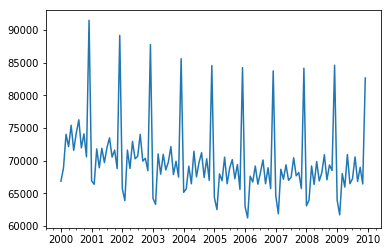

In [52]:
df = pd.read_csv("tsbook-master/FOOD.csv")
display(df.head())

# df["Month"] = df["Month"].apply(lambda  x: "{:02d}".format(x))
# pd.to_datetime(df[["Year", "Month"]].apply(lambda x: "-".join(x.astype(str)), axis=1),  format="%Y-%m")

df.columns = df.columns.str.lower()
df["day"] = 1
df.index = pd.to_datetime(df[["year", "month", "day"]])
y = df["expenditure"]

y.plot()

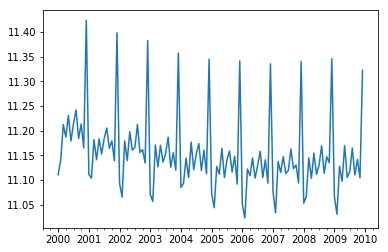

In [53]:
y = np.log(y)
y.plot()

In [54]:
mod = sm.tsa.UnobservedComponents(y, level="lltrend", seasonal=12)
mod_fit = mod.fit()
mod_fit.summary()

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                   expenditure   No. Observations:                  120
Model:                    local linear trend   Log Likelihood                 311.350
                   + stochastic seasonal(12)   AIC                           -614.701
Date:                       Tue, 25 Dec 2018   BIC                           -604.010
Time:                               16:24:33   HQIC                          -610.367
Sample:                           01-01-2000                                         
                                - 12-01-2009                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  9.306e-05   1.53e-05      6.067      0.000     6.3e-05       0.000
sigma2.level      3.132e-06    3.5e-06      0.894      0.371   -3.74e-06       1e-05
sigma2.trend      1.816e-08   2.73e-08      0.665      0.506   -3.54e-08    7.17e-08
sigma2.seasonal   4.214e-06   3.12e-06      1.351      0.177    -1.9e-06    1.03e-05
===================================================================================
Ljung-Box (Q):                       70.40   Jarque-Bera (JB):                10.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.16   Skew:                             0.71
Prob(H) (two-sided):                  0.67   Kurtosis:                         3.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1676: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


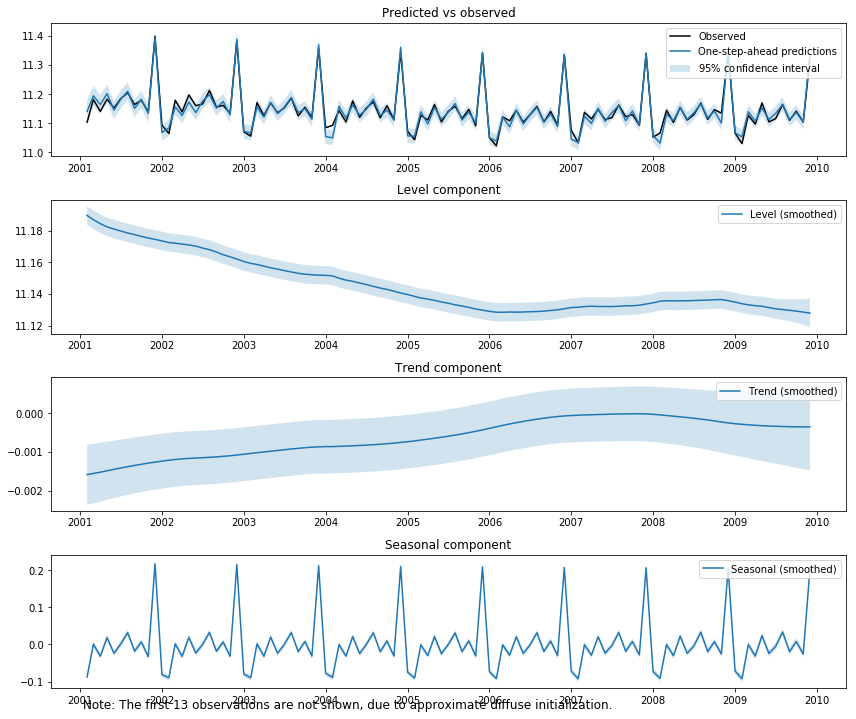

In [55]:
mod_fit.plot_components(figsize=(12, 10))
plt.tight_layout()
plt.show()

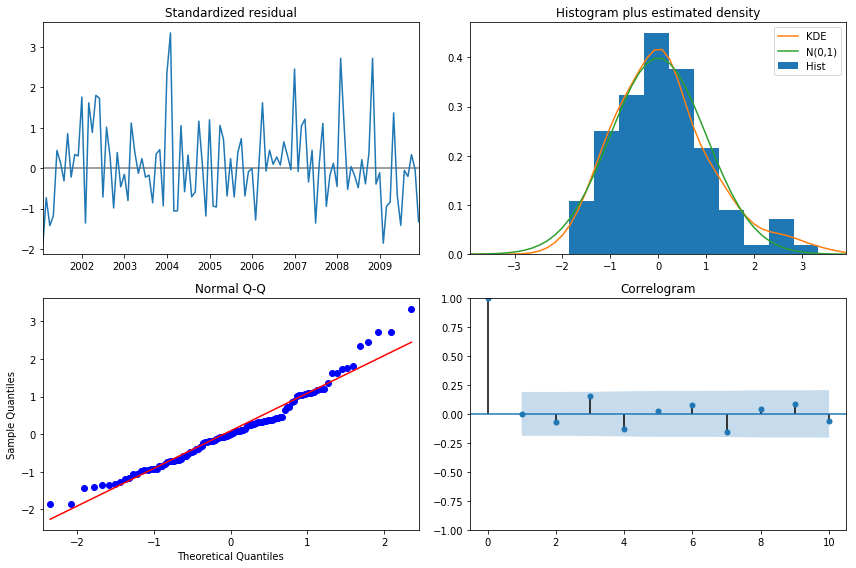

In [56]:
mod_fit.plot_diagnostics(figsize=(12, 8))
plt.tight_layout()
plt.show()

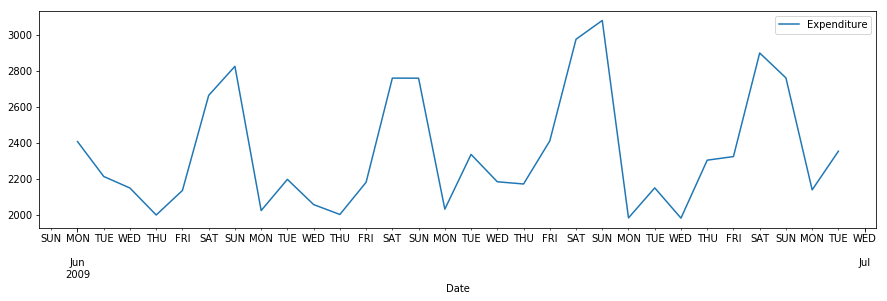

In [57]:
df_day = pd.read_csv("tsbook-master/FOOD_DAY.csv", index_col=0, parse_dates=[0])

weekday_map= {0:'MON', 1:'TUE', 2:'WED', 3:'THU', 4:'FRI', 5:'SAT', 6:'SUN'}
wd = df_day.index.dayofweek.map(weekday_map)

ax = df_day.plot(figsize=(15,4))
xticks = ax.get_xticks(minor=True)
xtick_dates = pd.to_datetime(xticks, unit="D")
lab = ax.set_xticklabels(xtick_dates.dayofweek.map(weekday_map).values, minor=True)

In [58]:
# 曜日効果を導入する
# 当該月の (平日の日数) - (休日の日数)
import jpholiday

end_id = df.index[-1]
end_date = pd.Timestamp(end_id.year, end_id.month, end_id.daysinmonth)

days = pd.date_range(df.index[0], end_date)
natioanal_holiday = days.map(lambda x: jpholiday.is_holiday(x.date()))
regular_holiday = days.weekday.isin([5, 6]) # 5: Saturday, 6: Sunday
is_holiday = np.logical_or(natioanal_holiday, regular_holiday)

holiday_info = pd.Series(is_holiday, days)
holiday_info = holiday_info.groupby([holiday_info.index.year, holiday_info.index.month]).value_counts()

weekday_efffect = holiday_info.xs(False, level=2) - holiday_info.xs(True, level=2)
exog = weekday_efffect.reset_index()
exog.columns = ["year", "month", "weekday"]

exog["day"] = 1
exog.index = pd.to_datetime(exog[["year", "month", "day"]])

exog["leap_year"] = np.logical_and(exog.index.is_leap_year, exog.index.month == 2).astype(int)
exog.drop(["year", "month", "day"], axis=1, inplace=True)

exog.head()

,weekday,leap_year
2000-01-01,9,0
2000-02-01,11,1
2000-03-01,13,0
2000-04-01,10,0
2000-05-01,9,0


/Users/yuho.kida/python_DS/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            Unobserved Components Results                            
=====================================================================================
Dep. Variable:                   expenditure   No. Observations:                  120
Model:                           local level   Log Likelihood                 353.051
                   + stochastic seasonal(12)   AIC                           -696.103
Date:                       Tue, 25 Dec 2018   BIC                           -682.692
Time:                               16:24:35   HQIC                          -690.665
Sample:                           01-01-2000                                         
                                - 12-01-2009                                         
Covariance Type:                         opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  2.357e-05   8.41e-06      2.802      0.005    7.08e-06    4.01e-05
sigma2.level      1.852e-05   5.59e-06      3.310      0.001    7.55e-06    2.95e-05
sigma2.seasonal    2.21e-06   1.57e-06      1.412      0.158   -8.58e-07    5.28e-06
beta.weekday        -0.0030      0.000     -7.104      0.000      -0.004      -0.002
beta.leap_year       0.0382      0.005      7.679      0.000       0.028       0.048
===================================================================================
Ljung-Box (Q):                       28.48   Jarque-Bera (JB):                23.09
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               0.86   Skew:                             0.18
Prob(H) (two-sided):                  0.65   Kurtosis:                         5.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

/Users/yuho.kida/python_DS/lib/python3.7/site-packages/statsmodels/tsa/statespace/structural.py:1676: RuntimeWarning: invalid value encountered in sqrt
  std_errors = np.sqrt(component_bunch['%s_cov' % which])


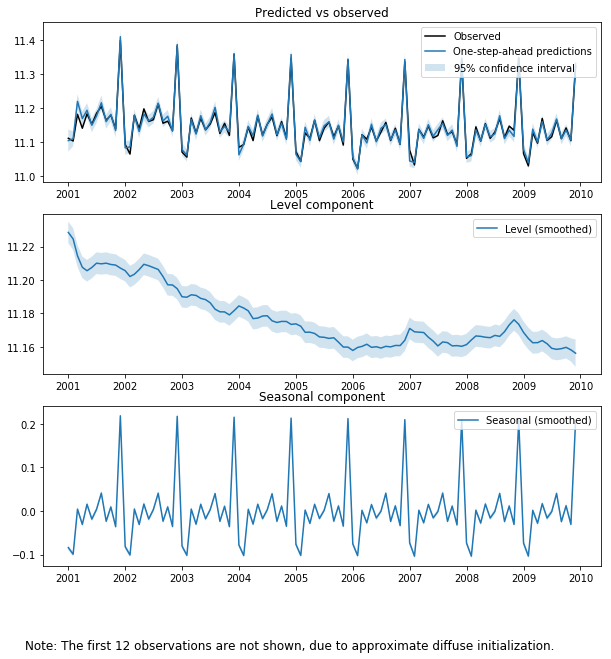

In [59]:
mod = sm.tsa.UnobservedComponents(y, level="llevel", seasonal=12, exog=exog)
mod_fit = mod.fit()
display(mod_fit.summary())

mod_fit.plot_components(figsize=(10, 10))
plt.show()

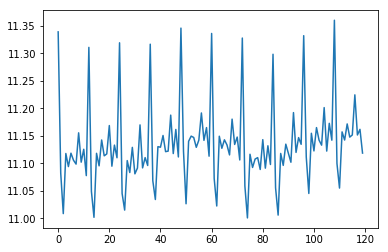

In [61]:
# exogが決まっているので、長さは元のデータと同じ必要がある。
mod_fit.simulate(120, initial_state=mod_fit.filtered_state[:,-1]).plot()


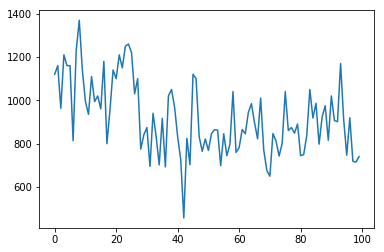

In [62]:
Nile= [1120,1160, 963,1210,1160,1160, 813,1230,1370,1140, 995, 935, 
       1110, 994,1020, 960,1180, 799, 958,1140,1100,1210,1150,1250,
       1260,1220,1030,1100, 774, 840, 874, 694, 940, 833, 701, 916, 
       692,1020,1050, 969, 831,726, 456, 824, 702,1120,1100, 832, 764,
       821, 768, 845,864, 862,698, 845, 744, 796,1040, 759, 781, 865,
       845, 944, 984, 897, 822,1010, 771, 676, 649, 846, 812, 742, 801,
       1040, 860, 874,848, 890, 744, 749, 838,1050, 918, 986, 797, 923,
       975, 815,1020, 906, 901,1170, 912, 746, 919, 718, 714, 740]

plt.plot(Nile)

In [63]:
mod_ll = sm.tsa.UnobservedComponents(Nile, "llevel")
res_mod_ll = mod_ll.fit()
res_mod_ll.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Unobserved Components Results                         
==============================================================================
Dep. Variable:                      y   No. Observations:                  100
Model:                    local level   Log Likelihood                -632.538
Date:                Tue, 25 Dec 2018   AIC                           1269.076
Time:                        16:24:43   BIC                           1274.266
Sample:                             0   HQIC                          1271.176
                                - 100                                         
Covariance Type:                  opg                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.508e+04   2586.506      5.829      0.000       1e+04    2.01e+04
sigma2.level      1478.8117    851.329      1.737      0.082    -189.762    3147.385
===================================================================================
Ljung-Box (Q):                       35.98   Jarque-Bera (JB):                 0.04
Prob(Q):                              0.65   Prob(JB):                         0.98
Heteroskedasticity (H):               0.61   Skew:                            -0.03
Prob(H) (two-sided):                  0.17   Kurtosis:                         3.08
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [64]:
sim_data = res_mod_ll.simulate(nsimulations=500)

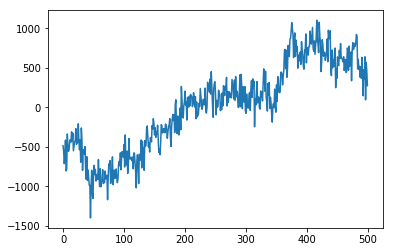

In [65]:
plt.plot(sim_data)

In [66]:
mod_ll.initial_variance
# mod_ll.start_params
mod_ll

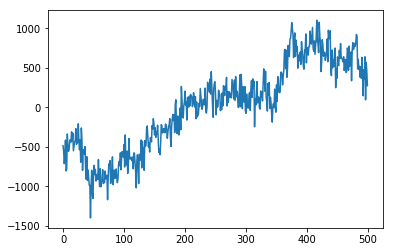

In [67]:
plt.plot(sim_data)

statsmodelsのUnobservedComponentsではinitializationを指定することができない。  
pythonで実施する場合、1. スクラッチ実装(最尤推定、またはStan, PyMC3で推論)、 2. statsmodelsのMLEmodelをカスタマイズ